In [15]:
import hkvfewspy as hkv
from datetime import datetime, timedelta 
from dateutil.relativedelta import relativedelta
import pandas as pd
#import altair as alt
import altair.vegalite.v3 as alt
from hkvportal.io.services import dataportal as dp
# parse data into Altair as json URL object
alt.data_transformers.enable('csv')

DataTransformerRegistry.enable('csv')

In [16]:
hkv.__version__

'0.6.3'

In [17]:
date_to = datetime.now() + timedelta(days=9)
date_to = date_to.replace(hour=0, minute=0, second=0, microsecond=0)

date_from = datetime.now() - relativedelta(months=3)
date_from = date_from.replace(hour=0, minute=0, second=0, microsecond=0)

print(date_from, date_to)

2019-01-23 00:00:00 2019-05-02 00:00:00


In [4]:
pi = hkv.Pi()
pi.setClient(wsdl='http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl')

In [5]:
# create query forecast data
query = pi.setQueryParameters(prefill_defaults=True)
query.parameterIds(['m3.minDepth.cut.f', 'm3.minDepth.cut'])
query.startTime(date_from)
query.endTime(date_to)
query.clientTimeZone('Etc/GMT-1')
# get as dataFrame
df = pi.getTimeSeries(queryParameters=query, setFormat='df')
# reset dataframe
df.reset_index(inplace=True)

In [6]:
# set noData value
df.loc[df['value'] == -999.,'value'] = pd.np.nan
#df.loc[df['value'] == 0.,'value'] = pd.np.nan

In [7]:
df = df[['date','parameterId','locationId','stationName','value']]
#df.head()

In [8]:
df['parameterId'] = df['parameterId'].str.replace('m3.minDepth.cut.f', 'Voorspelde volumes')
df['parameterId'] = df['parameterId'].str.replace('m3.minDepth.cut', 'Actuele volumes')

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
stations = df.stationName.unique().tolist()
parameters = df.parameterId.unique().tolist()

In [10]:
for parameter in ['Voorspelde volumes']:#parameters:
    for station in stations:
        sel = df[(df['parameterId']==parameter) & (df['stationName']==station)]#['value']
        sel1d = sel.value.diff(1)
        slice_idx = sel1d.index[sel1d != 0].tolist()  
        if parameter == 'Voorspelde volumes':
            g = sel1d
            #print(station, g.tail(3))
            slice_idx.append(sel1d.index[-2])
        slice_idx = list(sorted(set(slice_idx)))
        slice_idx            
        
        df.loc[(df['parameterId']==parameter) & (df['stationName']==station),'value'] = df.iloc[slice_idx]
df.loc[(df['value'] == 0.) & (df['parameterId'] == 'Actuele volumes'), 'value'] = pd.np.nan
df.dropna(inplace=True)        

c:\programdata\miniconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
#df.shape

In [18]:
#df['stationName'].unique().tolist()

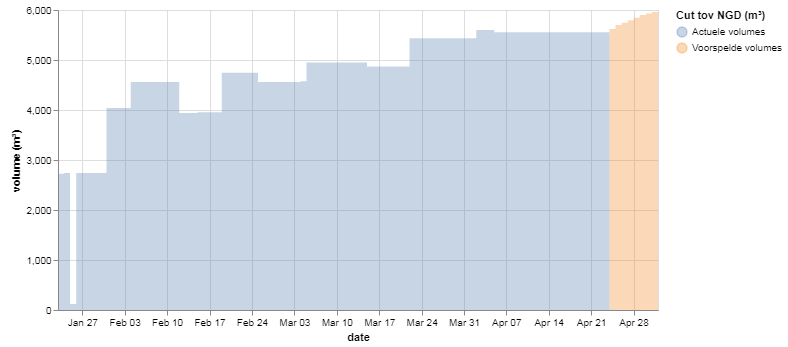

In [21]:
# CHART
rangeStep = 8
totalWith = rangeStep * len(df.date.unique())

# inlcude dropdown filter
loc_dropdown = alt.binding_select(options=df['stationName'].unique().tolist())
loc_select = alt.selection_single(fields=['stationName'], bind=loc_dropdown, name='location', init={"stationName": "Holwerd - Ameland, VA13 - VA25"})

line = alt.Chart().mark_area(opacity=0.3, interpolate='step-before').encode(
    x='date',
    y=alt.Y(field='value', type='quantitative', scale=alt.Scale(zero=False), title='volume (m³)'),
    color=alt.Color('parameterId', legend=alt.Legend(title="Cut tov NGD (m³)")),
    tooltip=[alt.Tooltip('stationName:N'),
             alt.Tooltip('value:Q'),
             alt.Tooltip('date:T', format='%A, %B %e')]#['locationId', 'stationName', 'value', 'date']
)

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection_single(nearest=True, on='mouseover', fields=['date'], empty='none', name='nearest')

# add interaction line
# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart().mark_point().encode(
    x='date',
    opacity=alt.value(0),
).add_selection(
    nearest
).transform_filter(loc_select)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
).transform_filter(loc_select)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'value', alt.value(' '))
).transform_filter(loc_select)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='date',
).transform_filter(nearest)

lines = line.add_selection(loc_select).transform_filter(loc_select)

# Put the five layers into a chart and bind the data
alt.layer(lines, selectors, points, rules, text,
          data=df, width=600, height=300)

In [22]:
dp = dp()

In [23]:
#dp.setDataservice(dataservice = 'http://85.17.82.66/dataservices/')
dp.setDataservice(dataservice = 'https://dmws.hkvservices.nl/dataportal/')

dataservice is set. https://dmws.hkvservices.nl/dataportal/ will be used as portal


In [24]:
dp.createDatabase(database='OMSWaddenzee')

{'database': 'OMSWaddenzee',
 'version': '0.2.0.0',
 'date': '2019-04-23 13:09:17'}

In [25]:
dp.setEntryDatabase(database = 'OMSWaddenzee', 
                    key = 'voorspelling', 
                    data = df.to_csv(index=False), 
                    description = 'voorspelling')

{'id': 'c3c424bd-d01b-4080-9ab7-d52bf2ab1b7e',
 'key': 'voorspelling',
 'date': '2019-04-23 13:09:25'}

In [26]:
dp.getEntryDatabase(database='OMSWaddenzee', key='voorspelling')

https://dmws.hkvservices.nl/dataportal/data.asmx/read?database=OMSWaddenzee&key=voorspelling


JSONDecodeError: Expecting value: line 1 column 1 (char 0)